# Data Preprocessing

* Denoising: Remove background noise and enhance ridge clarity.
* Sharpening: Highlight fine ridge structures.
* Histogram Equalization: Improve contrast and pattern visibility.
* Resizing: Standardized images to 224×224 pixels for consistency and model input.
* Outcome: Ensures clean, uniform fingerprints for feature extraction and deep learning training

# Before Preprocessing

Found 6001 files belonging to 8 classes.
Class Indices: {'A-': 0, 'A+': 1, 'AB-': 2, 'AB+': 3, 'B-': 4, 'B+': 5, 'O-': 6, 'O+': 7}


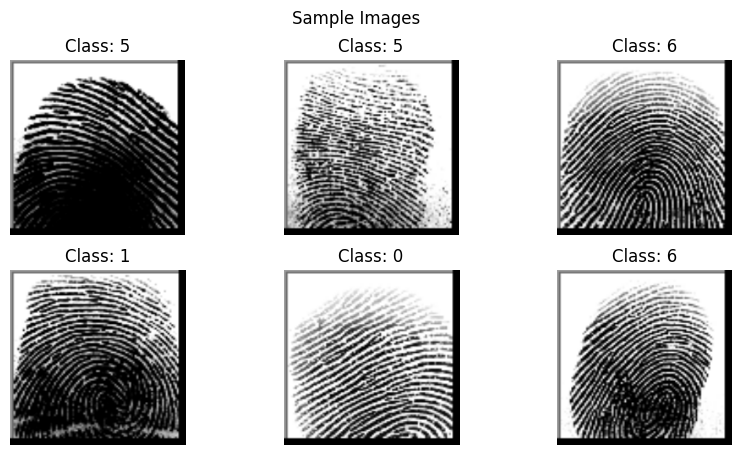

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\mdtan\Downloads\data\dataset_blood_group",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

images, labels = next(iter(dataset))


images = images.numpy().astype("uint8")

# Display first 6 raw images
plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[i]}")
    plt.axis("off")
print("Class Indices:", train_generator.class_indices)
plt.suptitle("Sample Images ")
plt.show()


In [ ]:
import cv2
import numpy as np
import os

# --- PARAMETERS ---
INPUT_ROOT  = r"C:\Users\mdtan\Downloads\data\dataset_blood_group"
OUTPUT_ROOT = r"C:\Users\mdtan\OneDrive\Desktop\output"
IMG_EXTS    = (".bmp", ".BMP", ".jpg", ".jpeg", ".png")  # adjust as needed

# Enhancement params
denoise_h      = 10
denoise_hColor = 10
denoise_templateWindowSize = 7
denoise_searchWindowSize   = 21
# Sharpening kernel
kernel_sharpen = np.array([
    [-1, -1, -1],
    [-1,  9, -1],
    [-1, -1, -1]
])
alpha = 1.2  # contrast
beta  = 20   # brightness
TARGET_SIZE = (128, 128)

# Walk input directory
for class_name in os.listdir(INPUT_ROOT):
    class_in = os.path.join(INPUT_ROOT, class_name)
    if not os.path.isdir(class_in):
        continue

    # Prepare output class directory
    class_out = os.path.join(OUTPUT_ROOT, class_name)
    os.makedirs(class_out, exist_ok=True)

    # Process each image in this class
    for fname in os.listdir(class_in):
        if not fname.endswith(IMG_EXTS):
            continue

        in_path  = os.path.join(class_in, fname)
        out_path = os.path.join(class_out, os.path.splitext(fname)[0] + "_enhanced.bmp")

        # Load
        img = cv2.imread(in_path)
        if img is None:
            print(f"⚠️ Skipping unreadable file: {in_path}")
            continue

        # 1) Denoise
        den = cv2.fastNlMeansDenoisingColored(
            img, None,
            denoise_h, denoise_hColor,
            denoise_templateWindowSize,
            denoise_searchWindowSize
        )

        # 2) Sharpen
        sharp = cv2.filter2D(den, -1, kernel_sharpen)

        # 3) Adjust brightness/contrast
        adj = cv2.convertScaleAbs(sharp, alpha=alpha, beta=beta)

        # 4) Resize
        resized = cv2.resize(adj, TARGET_SIZE, interpolation=cv2.INTER_AREA)

        # 5) Save enhanced image
        cv2.imwrite(out_path, resized)

    print(f"Processed class '{class_name}' → '{class_out}'")

print("✅ All images processed.")


Processed class 'A+' → 'C:\Users\mdtan\OneDrive\Desktop\output\A+'
Processed class 'A-' → 'C:\Users\mdtan\OneDrive\Desktop\output\A-'
Processed class 'AB+' → 'C:\Users\mdtan\OneDrive\Desktop\output\AB+'
Processed class 'AB-' → 'C:\Users\mdtan\OneDrive\Desktop\output\AB-'
Processed class 'B+' → 'C:\Users\mdtan\OneDrive\Desktop\output\B+'
Processed class 'B-' → 'C:\Users\mdtan\OneDrive\Desktop\output\B-'
Processed class 'O+' → 'C:\Users\mdtan\OneDrive\Desktop\output\O+'
Processed class 'O-' → 'C:\Users\mdtan\OneDrive\Desktop\output\O-'
✅ All images processed.


In [ ]:
import os
import random
import shutil

# Set your paths
dataset_dir = r'C:\Users\mdtan\OneDrive\Desktop\output'
output_dir = r'C:\Users\mdtan\SCOPUS Project'

# Fixed classes
classes = ['A-', 'A+', 'AB-', 'AB+', 'B-', 'B+', 'O-', 'O+']

# Fix random seed for reproducibility
random.seed(42)

# Create split directories
splits = ['test_data','val_data']

for split in splits:
    for class_name in classes:
        split_class_dir = os.path.join(output_dir, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

# Randomly select images and move
for class_name in classes:
    class_dir = os.path.join(dataset_dir, class_name)
    images = os.listdir(class_dir)
    random.shuffle(images)

    # Select 150 random images from the class
    selected_images = images[:300]
    val_images = selected_images[:150]
    test_images = selected_images[150:]

    # Move images
    for img in val_images:
        src_path = os.path.join(class_dir, img)
        dst_path = os.path.join(output_dir, 'val_data', class_name, img)
        shutil.move(src_path, dst_path)

    for img in test_images:
        src_path = os.path.join(class_dir, img)
        dst_path = os.path.join(output_dir, 'test_data', class_name, img)
        shutil.move(src_path, dst_path)

    print(f'Class: {class_name} - Val: {len(val_images)}, Test: {len(test_images)}')

print('\nImage selection and splitting completed successfully!')


Class: A- - Val: 150, Test: 150
Class: A+ - Val: 150, Test: 150
Class: AB- - Val: 150, Test: 150
Class: AB+ - Val: 150, Test: 150
Class: B- - Val: 150, Test: 150
Class: B+ - Val: 150, Test: 150
Class: O- - Val: 150, Test: 150
Class: O+ - Val: 150, Test: 150

Image selection and splitting completed successfully!


In [ ]:
import os
import cv2
import numpy as np
from fingerprint_enhancer import enhance_fingerprint
from tqdm import tqdm

# Root directory containing class folders
ROOT_DIR = r"C:\Users\mdtan\SCOPUS Project\output" # <- change this to your actual path

def enhance_and_convert_bmp_to_jpg(img_path):
    img = cv2.imread(img_path, 0)  # Read as grayscale
    if img is None:
        print(f"Failed to read: {img_path}")
        return

    try:
        # Resize and enhance
        img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
        img = cv2.equalizeHist(img)
        enhanced = enhance_fingerprint(img)
        enhanced = (enhanced * 255).astype(np.uint8)

        # Save as JPG
        jpg_path = img_path.rsplit('.', 1)[0] + ".jpg"
        cv2.imwrite(jpg_path, enhanced)

        # Remove original BMP
        os.remove(img_path)

    except Exception as e:
        print(f"Failed processing {img_path}: {e}")

# Process all class directories
for class_name in os.listdir(ROOT_DIR):
    class_dir = os.path.join(ROOT_DIR, class_name)
    if not os.path.isdir(class_dir):
        continue

    # Process all BMP files in the class directory
    bmp_files = [f for f in os.listdir(class_dir) if f.lower().endswith('.bmp')]
    for file in tqdm(bmp_files, desc=f"Processing {class_name}"):
        bmp_path = os.path.join(class_dir, file)
        enhance_and_convert_bmp_to_jpg(bmp_path)

print("All images processed successfully!")

Processing .ipynb_checkpoints: 0it [00:00, ?it/s]
Processing O-: 100%|█████████████████████████████████████████████████████████████████| 413/413 [23:35<00:00,  3.43s/it]

All images processed successfully!


In [ ]:
import os
import cv2
import numpy as np
from fingerprint_enhancer import enhance_fingerprint
from tqdm import tqdm

# Root directory containing 'train', 'val', 'test' folders
ROOT_DIR = r"C:\Users\mdtan\SCOPUS Project"

def enhance_and_save_image(img_path, output_path=None):
    """Enhance and save fingerprint image"""
    img = cv2.imread(img_path, 0)  # Read as grayscale
    if img is None:
        print(f"Failed to read: {img_path}")
        return

    try:
        # Resize and enhance
        img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
        img = cv2.equalizeHist(img)
        enhanced = enhance_fingerprint(img)
        enhanced = (enhanced * 255).astype(np.uint8)

        # Determine output path
        if output_path is None:
            output_path = img_path.rsplit('.', 1)[0] + ".jpg"

        # Save as JPG
        cv2.imwrite(output_path, enhanced)
        return True

    except Exception as e:
        print(f"Failed processing {img_path}: {e}")
        return False

def process_dataset_split(split_dir):
    """Process all images in a dataset split (train/val/test)"""
    if not os.path.exists(split_dir):
        print(f"Directory not found: {split_dir}")
        return

    for class_name in os.listdir(split_dir):
        class_dir = os.path.join(split_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        # Process all image files in the class directory
        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))]
        for file in tqdm(image_files, desc=f"Processing {os.path.basename(split_dir)}/{class_name}"):
            img_path = os.path.join(class_dir, file)

            # Only process if it's BMP or if we want to reprocess all images
            if file.lower().endswith('.bmp'):
                if enhance_and_save_image(img_path):
                    os.remove(img_path)  # Remove original BMP
            else:
                # For non-BMP images, just enhance and overwrite
                enhance_and_save_image(img_path, output_path=img_path)

def main():
    # Process each dataset split
    for split in ['val', 'test']:
        split_dir = os.path.join(ROOT_DIR, split)
        print(f"\nProcessing {split} data...")
        process_dataset_split(split_dir)

    print("\nAll images processed successfully!")

if __name__ == "__main__":
    main()


Processing val data...


Processing val/O-: 100%|█████████████████████████████████████████████████████████████| 150/150 [09:16<00:00,  3.71s/it]



Processing test data...


Processing test/O-: 100%|████████████████████████████████████████████████████████████| 150/150 [09:08<00:00,  3.66s/it]


All images processed successfully!


After Processing and Augmenting fingerprint Samples

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

classes=['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']
img_height, img_width = 256, 256
batch_size = 32
dataset_dir = r"C:\Users\mdtan\processed_data"
train_datagen = ImageDataGenerator(
   rescale=1./255,
        rotation_range=7,
)



val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',classes=classes,shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'val'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',classes=classes
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',classes=classes,
    shuffle=False
)

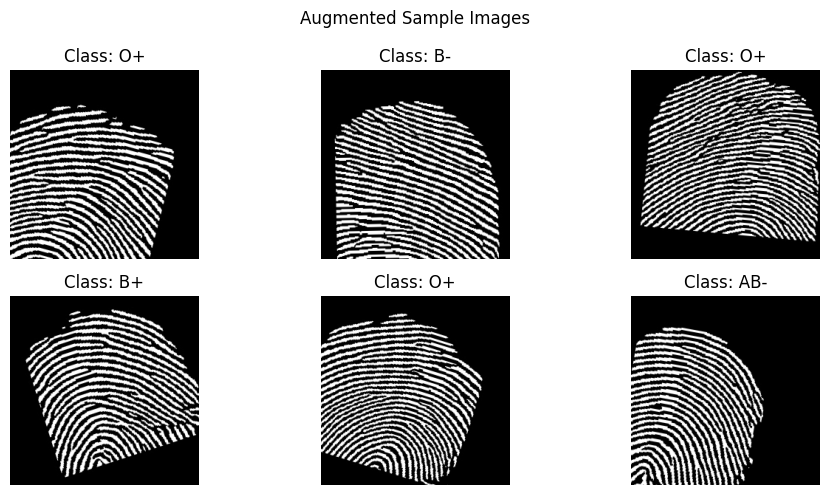

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Get one batch of augmented images and labels
images, labels = next(train_generator)

# Convert labels from one-hot to class indices
class_indices = {v: k for k, v in train_generator.class_indices.items()}
label_indices = np.argmax(labels, axis=1)
label_names = [class_indices[idx] for idx in label_indices]

# Plot first 6 augmented images
plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Class: {label_names[i]}")
    plt.axis("off")

plt.suptitle("Augmented Sample Images")
plt.tight_layout()
plt.show()
